In [4]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from PIL import Image
import time

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [7]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [8]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 5000 # 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 100 # 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_valid_split=0.6, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_valid_split (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_valid_split)

    # 4. Split into validation and testing sets
    valid_size = int(len(caption_data) * (1 - train_valid_split) / 2)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size: train_size + valid_size]
    }

    testing_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size + valid_size:]
    }

    # 4. Return the splits
    return training_data, validation_data, testing_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data, testing_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))
print("Number of testing samples: ", len(testing_data))

Number of training samples:  4680
Number of validation samples:  1560
Number of testing samples:  1561


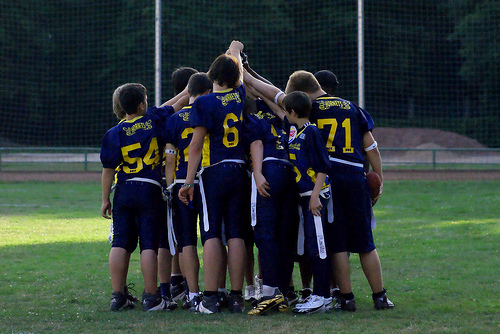

In [10]:
# load image
import random

images = list(train_data.keys())
img_path = images[random.randint(0, len(images))]
Image.open(img_path)

In [11]:
train_data[img_path]

['<start> A group of children wearing blue and yellow uniforms put their hangs together . <end>',
 '<start> A soccer team with blue jerseys is huddled together with their hands touching above their heads . <end>',
 '<start> A young flag football team are huddled together . <end>',
 '<start> Boys huddle during a soccer game . <end>',
 '<start> Soccer players in blue before a game . <end>']

In [12]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
# image_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(0.2),
#         layers.RandomContrast(0.3),
#     ]
# )

In [13]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=vectorization.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=vectorization.get_vocabulary(),
    invert=True)

In [14]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

test_dataset = make_dataset(list(testing_data.keys()), list(testing_data.values()))

In [15]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 100), dtype=tf.int64, name=None))>

In [16]:
valid_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 100), dtype=tf.int64, name=None))>

In [17]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 100), dtype=tf.int64, name=None))>

## InceptionV3 as Encoder

In [18]:
def get_cnn_model():
    image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
    # We freeze our feature extractor
    image_model.trainable = False
    base_model_out = image_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(image_model.input, base_model_out)
    return cnn_model

In [19]:
get_cnn_model()

87924736/87910968 [==============================] - 2s 0us/step


## gMLP

### gMLP Architecture
From https://github.com/lucidrains/g-mlp-pytorch

In [20]:
import tensorflow as tf
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import Layer, LayerNormalization
from einops import rearrange, repeat
from random import randrange

In [21]:
def exists(val):
    return val is not None

In [22]:
def dropout_layers(layers, prob_survival):
    if prob_survival == 1:
        return layers

    num_layers = len(layers)
    to_drop = tf.random.uniform([num_layers], minval=0., maxval=1.) > prob_survival

    # make sure at least one layer makes it
    if all(to_drop):
        rand_index = randrange(num_layers)
        to_drop[rand_index] = False

    layers = [layer for (layer, drop) in zip(layers, to_drop) if not drop]
    return layers

In [23]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, d_out, d_attn, causal = False):
        super().__init__()
        
        self.d_attn = d_attn
        self.scale = d_attn ** -0.5

        self.proj_in = tf.keras.layers.Dense(3 * d_attn)
        self.proj_out = tf.keras.layers.Dense(d_out)
        self.causal = causal

    def call(self, x):
        qkv = self.proj_in(x)
        q, k, v = tf.split(qkv, num_or_size_splits=3, axis=-1)
        w = tf.einsum('bid,bjd->bij', q, k) * self.scale

        if self.causal:
            mask = tf.ones(w.shape[-2:])

            # band_part and set_diag replace triu(1) in lucidrains' implementation
            mask = tf.linalg.band_part(mask, 0, -1)
            mask_diag = tf.linalg.diag_part(mask)
            mask = tf.linalg.set_diag(mask, tf.zeros_like(mask_diag))
            mask = tf.cast(mask, dtype=tf.bool)

            w = tf.where(mask[None, ...], tf.ones_like(w) * -q.dtype.max, w)

        a = tf.nn.softmax(w * tf.math.rsqrt(float(self.d_attn)), axis=-1)
        out = tf.einsum('bij,bjd->bid', a, v)
        return self.proj_out(out)

In [24]:
class SpatialGatingUnit(Layer):
    def __init__(self, 
                dim_seq, 
                causal = False, 
                activation = tf.identity, 
                heads = 1,
                init_eps = 1e-3,
                circulant_matrix = False,
                kernel_regularizer=None,
                bias_regularizer=None):
        
        super().__init__()
        self.dim_seq = dim_seq
        self.causal = causal
        self.activation = activation
        self.init_eps = init_eps / dim_seq

        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.heads = heads

        # parameters
        if circulant_matrix:
            self.circulant_pos_x = tf.ones((heads, dim_seq))
            self.circulant_pos_y = tf.ones((heads, dim_seq))

        self.circulant_matrix = circulant_matrix
        shape = (heads, dim_seq,) if circulant_matrix else (heads, dim_seq, dim_seq)
        self.shape = shape

        self.heads = heads

    def build(self, _):

        self.dense_bias = self.add_weight(
            name="sgu_dense_bias", 
            regularizer=self.bias_regularizer,
            shape=(self.heads, self.dim_seq), # 1 is the number of heads
            initializer=tf.ones
        )
        
        self.dense_weight = self.add_weight(
            name="sgu_dense_kernel", 
            regularizer=self.kernel_regularizer,
            shape=self.shape, 
            initializer=RandomUniform(minval=-self.init_eps, maxval=self.init_eps)
        )

        self.norm = LayerNormalization()

    def call(self, x, tiny_attn=None):
        device, n, h = x.device, x.shape[1], self.heads

        res, gate = tf.split(x, 2, axis=-1)
        gate = self.norm(gate)

        weight, bias = self.dense_weight, self.dense_bias
        
        if self.circulant_matrix:
            # build the circulant matrix
            dim_seq = weight.shape[-1]
            paddings = tf.constant([[0, 0], [0, dim_seq]])
            weight = tf.pad(weight, paddings, constant_values=0)
            weight = repeat(weight, '... n -> ... (r n)', r = dim_seq)
            weight = tf.reshape(weight[:, :-dim_seq], [h, dim_seq, 2 * dim_seq - 1])
            weight = weight[:, :, (dim_seq - 1):]

            # give circulant matrix absolute position awareness

            pos_x, pos_y = self.circulant_pos_x, self.circulant_pos_y
            weight = weight * rearrange(pos_x, 'h i -> h i ()') * rearrange(pos_y, 'h j -> h () j')
        
        if self.causal:
            weight, bias = weight[:, :n, :n], bias[:,:n]
            mask = tf.ones(weight.shape[-2:])

            # band_part and set_diag replace triu(1) in lucidrains' implementation
            mask = tf.linalg.band_part(mask, 0, -1)
            mask_diag = tf.linalg.diag_part(mask)
            mask = tf.linalg.set_diag(mask, tf.zeros_like(mask_diag))
            mask = tf.cast(mask, dtype=tf.bool)

            mask = rearrange(mask, 'i j -> () i j')
            weight = tf.where(mask, tf.zeros_like(weight), weight)


        gate = rearrange(gate, 'b n (h d) -> b h n d', h = h)


        gate = tf.einsum('bhnd, hmn->bhmd', gate, weight)
        gate = gate + rearrange(bias, 'h n -> () h n ()')

        gate = rearrange(gate, 'b h n d -> b n (h d)')
        
        if exists(tiny_attn):
            gate = gate + tiny_attn

        return self.activation(gate) * res # dimension at axis = -1 gets halved

In [25]:
# ***** gMLP-block works as a self-attention *****
class gMLP_Block(tf.keras.Model):
    def __init__(self, d_ffn, d_model, seq_len, heads=1, circulant_matrix = False, causal=False, attn_dim=None, act=tf.identity):
        super().__init__()
        
        self.norm_layer = tf.keras.layers.LayerNormalization(axis=-1)
        
        self.proj_in = tf.keras.layers.Dense(d_ffn, activation='gelu')

        # attention
        self.tiny_attn = Attention(d_ffn // 2, attn_dim, causal=causal) if attn_dim else None

        self.sgu = SpatialGatingUnit(seq_len, causal=causal, activation=act, heads=heads, circulant_matrix = circulant_matrix)
        self.proj_out = tf.keras.layers.Dense(d_model)
        
    def call(self, x):
        # word_embedding
        shortcut = x

        x = self.norm_layer(x)

        attn = self.tiny_attn(x) if self.tiny_attn else None

        x = self.proj_in(x)
        x = self.sgu(x, tiny_attn=attn)
        x = self.proj_out(x)
        
        x = x + shortcut
        
        return x

In [26]:
class gMLPDecoderLayer(tf.keras.layers.Layer):
    """
      Combine text embedding with image features
    """
    def __init__(self, d_ffn, d_model, seq_len, heads=1, circulant_matrix = False, causal=False, attn_dim=None, act=tf.identity):
        super().__init__()
        
        self.gmlp_block = gMLP_Block(d_ffn=d_ffn, d_model=d_model, heads=heads, seq_len=seq_len, attn_dim=attn_dim, causal=causal, act=act, circulant_matrix=circulant_matrix)
        # for image
        self.gmlp_block_2 = gMLP_Block(d_ffn=d_ffn, d_model=d_model, heads=heads, seq_len=seq_len, attn_dim=attn_dim, causal=causal, act=act, circulant_matrix=circulant_matrix)

    def call(self, x, enc_output):
        seq_len = tf.shape(x)[1]
        
        # look ahead mask
        out = self.gmlp_block(x)

        enc_output = tf.expand_dims(enc_output, axis=1)
        out = enc_output + out
        
        
        # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        out = self.gmlp_block_2(out)
        # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------

        return out

### gMLP NLP

In [27]:
# top k filtering

def top_k(logits, thres = 0.9):
    k = int((1 - thres) * logits.shape[-1])
    val, ind = tf.math.top_k(logits, k)
    probs = tf.fill(logits.shape, float('-inf'))
    probs.scatter_(1, ind, val)
    return probs

In [28]:
def eval_decorator(fn):
    def inner(model, *args, **kwargs):
        out = fn(model, *args, **kwargs)
        return out
    return inner

In [29]:
# import tensorflow_probability as tfp

In [30]:
# class AutogressiveWrapper(tf.keras.Model):
#     def __init__(self, net, ignore_index = -100, pad_value=0):
#         super().__init__()
#         self.pad_value = pad_value
#         self.ignore_index = ignore_index

#         self.net = net
#         self.max_seq_len = net.seq_len

#     \@eval_decorator
#     def generate(self, start_tokens, seq_len, eos_token = None, temperature = 1., filter_logits_fn = top_k, filter_thres = 0.9, **kwargs):
#         num_dims = len(start_tokens.shape)

#         if num_dims == 1:
#             start_tokens = start_tokens[None, :]

#         b, t = start_tokens.shape

#         out = start_tokens

#         for _ in range(seq_len):
#             x = out[:, -self.max_seq_len:]

#             # TODO: pass input features
#             logits = self.net(x, **kwargs)[:, -1, :]

#             filtered_logits = top_k(logits, thres = filter_thres)
#             probs = tf.nn.softmax(filtered_logits / temperature, dim=-1)

#             dist = tfp.distributions.Multinomial(1, probs=probs)
#             sample = tf.where(tf.equal(dist.sample(1)[0], 1))[0]

#             out = tf.concat([out, sample], axis=-1)

#             if eos_token is not None and (sample == eos_token).all():
#                 break

#         out = out[:, t:]

#         if num_dims == 1:
#             out = out.squeeze(0)
#         return out

#     def call(self, x, **kwargs):
#         xi, xo = x[:, :-1], x[:, 1:]
#         out = self.net(xi, **kwargs)
#         loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

#         loss = loss_function(xo, tf.transpose(out, perm=[1, 2]))
#         return loss

In [31]:
class gMLPNLP(tf.keras.Model):
    def __init__(self, *, num_tokens=None, embedding_dim, depth, seq_len, heads=1, ff_mult=4, attn_dim=None, prob_survival = 1., causal=False, circulant_matrix = False, act=tf.identity):
        super().__init__()
        
        assert (embedding_dim % heads) == 0, 'dimension must be divisible by number of heads'

        dim_ff = embedding_dim * ff_mult
        self.seq_len = seq_len
        self.prob_survival = prob_survival
        self.embedding_dim = embedding_dim
        
        self.to_embed = tf.keras.layers.Embedding(num_tokens, embedding_dim) if num_tokens else tf.identity

        self.gmlp_layers = [gMLPDecoderLayer(d_ffn=dim_ff, d_model=embedding_dim, heads=heads, seq_len=seq_len, attn_dim=attn_dim, causal=causal, act=act, circulant_matrix=circulant_matrix) for i in range(depth)]

        self.to_logits = tf.keras.Sequential([
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dense(num_tokens)
        ]) if num_tokens else tf.identity
        
    def call(self, x, img_features, is_training=True):        
        x = self.to_embed(x) # batch_size, seq_len, embedding_dim
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        gmlp_layers = self.gmlp_layers if not is_training else dropout_layers(self.gmlp_layers, self.prob_survival)
        
        for layer in gmlp_layers:
            x = layer(x, img_features)

        out = x
        return self.to_logits(out) # (batch_size, tar_seq_len, target_vocab_size)

## gMLPVision

In [32]:
def pair(val):
    return (val, val) if not isinstance(val, tuple) else val

In [33]:
class RearrangeLayer(tf.keras.layers.Layer):
    def __init__(self, patch_height, patch_width):
        super().__init__()
        self.patch_height = patch_height
        self.patch_width = patch_width

    def call(self, x):
        return rearrange(x, 'b (h p1) (w p2) c -> b (h w) (c p1 p2)', p1 = self.patch_height, p2 = self.patch_width)

In [34]:
class ReduceLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return tf.reduce_mean(x, 1)

In [35]:
class gMLPVision(tf.keras.Model):
    def __init__(
        self,
        *,
        image_size,
        patch_size,
        dim,
        depth,
        heads = 1,
        ff_mult=4, 
        channels = 3,
        attn_dim = None,
        prob_survival = 1.
    ):
        super().__init__()
        assert (dim % heads) == 0, 'dimension must be divisible by number of heads'

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert (image_height % patch_height) == 0 and (image_width % patch_width) == 0, 'image height and width must be divisible by patch size'
        num_patches = (image_height // patch_height) * (image_width // patch_width)

        dim_ff = dim * ff_mult

        self.to_patch_embed = tf.keras.Sequential(
            [
             RearrangeLayer(patch_height, patch_width), 
             tf.keras.layers.Dense(dim)]
        )

        self.prob_survival = prob_survival

        self.gmlp_layers = [gMLP_Block(d_model=dim, heads=heads, d_ffn=dim_ff, seq_len=num_patches, attn_dim=attn_dim) for _ in range(depth)]

        self.to_logits = tf.keras.Sequential(
          [tf.keras.layers.LayerNormalization(),
           ReduceLayer()]
        )
    def call(self, x, is_training=True):
        x = self.to_patch_embed(x)

        gmlp_layers = self.gmlp_layers if not is_training else dropout_layers(self.gmlp_layers, self.prob_survival)
        x = tf.keras.Sequential(gmlp_layers)(x)
        return self.to_logits(x)

### Simple Test

In [36]:
# model = gMLPVision(
#     image_size = 256,
#     patch_size = 16,
#     dim = 512,
#     depth = 6
# )

# img = tf.random.normal((1, 256, 256, 3)) # batch size, image_width, image_height, channel
# logits = model(img, is_training=True) # (1, 1000)

In [37]:
# model = gMLPNLP(
#     num_tokens = 20000,
#     embedding_dim = 512,
#     depth = 6,
#     seq_len = 256,
#     circulant_matrix = True,      # use circulant weight matrix for linear increase in parameters in respect to sequence length
#     act = tf.math.tanh               # activation for spatial gate (defaults to identity)
# )

# x = tf.random.uniform((1, 256), minval=0, maxval=20000)
# logits = model(x) # (1, 256, 20000)

In [38]:
# logits.shape

## Model Training

### Model Hyperparameters

In [39]:
num_layer = 1
d_model = 512
num_heads = 8
target_vocab_size = VOCAB_SIZE + 1 # + unknown token

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [41]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)

In [42]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# cnn_model = get_cnn_model()

encoder = gMLPVision(
    image_size = IMAGE_SIZE,
    patch_size = 13,
    dim = 512,
    depth = num_layer,
    attn_dim=64
    )
decoder = gMLPNLP(num_tokens=target_vocab_size, depth=num_layer, embedding_dim=d_model, heads=num_heads, seq_len=SEQ_LENGTH, causal=True, circulant_matrix=True, attn_dim=64) # attn_dim=64

### Checkpoint

In [43]:
checkpoint_path = '/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/gMLP_flicker_uncommented'

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

In [44]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    print(ckpt_manager.latest_checkpoint)
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/gMLP_flicker_uncommented/ckpt-20


In [45]:
print(start_epoch)

20


### Model Training

In [46]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [47]:
def train_step(img_tensor, tar, is_training):
    # 1. Get image embeddings
    # img_tensor = cnn_model(img_tensor)

    # 2. Pass each of the five captions one by one to the decoder
    # along with the encoder outputs and compute the loss as well as accuracy
    # for each caption.
    # num_captions_per_image = 5
    all_captions_loss = 0
    for i in range(5):
        tar_inp = tar[:, i, :-1]
        tar_real = tar[:, i, 1:]

        if is_training:
            with tf.GradientTape() as tape:
                features = encoder(img_tensor, is_training)
                predictions = decoder(tar_inp, features, is_training)

                loss = loss_function(tar_real, predictions)
                all_captions_loss += loss

                trainable_variables = encoder.trainable_variables + decoder.trainable_variables
                gradients = tape.gradient(loss, trainable_variables)   
                optimizer.apply_gradients(zip(gradients, trainable_variables))
        
                train_loss(loss)
                train_accuracy(tar_real, predictions)
        else:
            features = encoder(img_tensor, is_training)
            predictions = decoder(tar_inp, features, is_training)
            loss = loss_function(tar_real, predictions)

            val_loss(loss)
            val_accuracy(tar_real, predictions)

In [48]:
train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

for epoch in range(start_epoch, 21):
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(train_dataset):
      train_step(img_tensor, tar, True)
      if batch % 50 == 0:
         print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))
   train_losses.append(train_loss.result() / 5)
   train_accuracies.append(train_accuracy.result() / 5)

   # validation
   val_loss.reset_states()
   val_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(valid_dataset):
     train_step(img_tensor, tar, False)
     if batch % 50 == 0:
         print ('Epoch {} Batch {} Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(
         epoch + 1, batch, val_loss.result(), val_accuracy.result()))

   val_losses.append(val_loss.result() / 5)
   val_accuracies.append(val_accuracy.result() / 5)
   if epoch % 10 == 0:
      ckpt_manager.save(checkpoint_number=epoch)     

   print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
   
   print ('Epoch {} Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                               val_loss.result(),
                                               val_accuracy.result()))
   
   print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 21 Batch 0 Loss 0.7091 Accuracy 0.0993
Epoch 21 Batch 50 Loss 0.5555 Accuracy 0.1019
Epoch 21 Batch 0 Validation Loss 5.5237 Validation Accuracy 0.0367
Epoch 21 Loss 0.5516 Accuracy 0.1020
Epoch 21 Validation Loss 5.4752 Validation Accuracy 0.0359
Time taken for 1 epoch: 141.61146569252014 secs



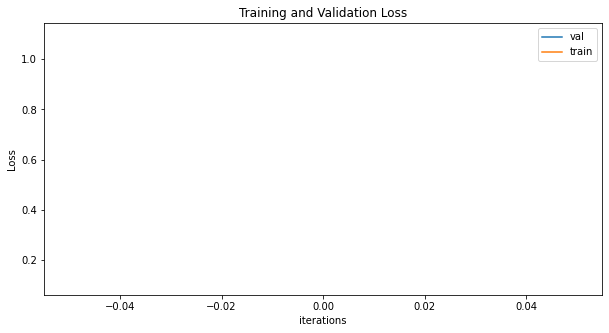

In [49]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

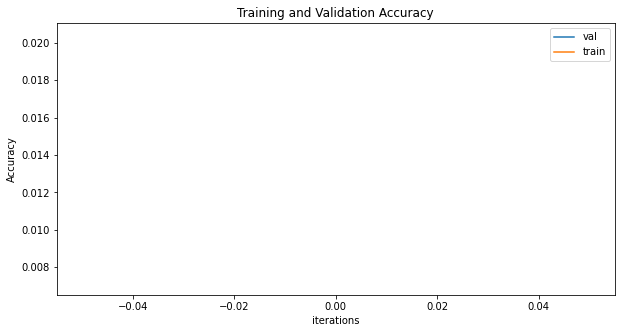

In [50]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracies,label="val")
plt.plot(train_accuracies,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Evaluation

In [51]:
from nltk.translate.bleu_score import sentence_bleu

In [52]:
def evaluate(image):
   temp_input = tf.expand_dims(decode_and_resize(image), 0)
   img_tensor_val = temp_input
  #  img_tensor_val = cnn_model(temp_input)
  #  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = word_to_index(tf.constant('<start>'))
   end_token = word_to_index(tf.constant('<end>'))
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(100):
      features = encoder(img_tensor_val)
      predictions = decoder(output, features)

      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int64)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0)
      result.append(tf.compat.as_text(index_to_word(int(predicted_id.numpy())).numpy()))
      output = tf.concat([output, predicted_id], axis=-1)

   return result,tf.squeeze(output, axis=0)

In [53]:
def test_single_img(id):
  test_images = list(testing_data.keys())
  image = test_images[id]

  captions = testing_data[image]
  bleu_scores = []
  for caption in captions:
    real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in vectorization(caption) if i not in [0]])
    caption, result = evaluate(image)

    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]

    for i in caption:
      if i=="<unk>":
          caption.remove(i)

    for i in real_caption:
      if i=="<unk>":
          real_caption.remove(i)

    result_join = ' '.join(caption)
    result_final = result_join.rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = caption

    # score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
    # print(f"BLEU-1 score: {score*100}")
    # score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
    # print(f"BLEU-2 score: {score*100}")
    # score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
    # print(f"BLEU-3 score: {score*100}")
    score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
    bleu_scores.append(score)
    print(f"BLEU-4 score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Predicted Caption:', ' '.join(caption))
    temp_image = np.array(Image.open(image))
    plt.imshow(temp_image)

  return np.mean(bleu_scores)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-4 score: 46.84677063277009
Real Caption: a person surfs in the curl of a wave [UNK] by the falling water
Predicted Caption: a surfer is falling into a big ocean wave
BLEU-4 score: 67.99308458396493
Real Caption: a person surfs through a wave as it crashes down
Predicted Caption: a surfer is falling into a big ocean wave


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-4 score: 33.584386823726156
Real Caption: a surfer is riding in the barrel of a wave
Predicted Caption: a surfer is falling into a big ocean wave
BLEU-4 score: 73.0633242658635
Real Caption: someone is surfing underneath a wave on a white surfboard
Predicted Caption: a surfer is falling into a big ocean wave
BLEU-4 score: 48.54917717073234
Real Caption: the large wave is crashing down over a surfer
Predicted Caption: a surfer is falling into a big ocean wave


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.5400734869541141

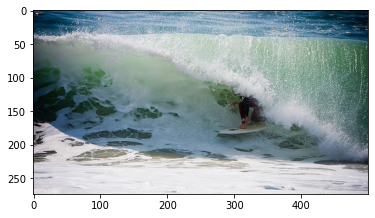

In [57]:
test_single_img(52)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-4 score: 28.409305819806306
Real Caption: football players wearing orange uniforms are tackling a player in a white uniform
Predicted Caption: a football player in orange being tackled by a player in blue


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-4 score: 41.722614486115056
Real Caption: a tackle in a football game
Predicted Caption: a football player in orange being tackled by a player in blue


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-4 score: 63.89431042462724
Real Caption: three footballers in a tackle
Predicted Caption: a football player in orange being tackled by a player in blue
BLEU-4 score: 38.827267775222325
Real Caption: three men are involved in a football game are tackling each other
Predicted Caption: a football player in orange being tackled by a player in blue
BLEU-4 score: 38.386658421682654
Real Caption: two players take down the player with the ball in a football game
Predicted Caption: a football player in orange being tackled by a player in blue
BLEU-4 score: 60.42750794713536
Real Caption: a goalie is guarding the goal
Predicted Caption: three people prepare a table full of food with a police car in the background
BLEU-4 score: 50.813274815461476
Real Caption: kids in helmets play hockey outside
Predicted Caption: three people prepare a table full of food with a police car in the background
BLEU-4 score: 66.8740304976422
Real Caption: several players playing a game of hockey outside on the r

KeyboardInterrupt: ignored

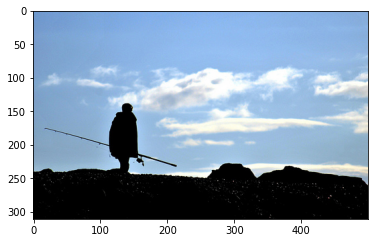

In [ ]:
bleu_scores = []
for i in range(len(testing_data)):
  bleu_score = test_single_img(i)
  bleu_scores.append(bleu_score)

np.mean(bleu_scores)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.